# Introduction to Image Classification


## Overview


## Imports

 

In [1]:
import numpy as np
import gzip # This is used in extracting the images

import matplotlib.pyplot as plt # In order to plot the images to see what we are dealing with
from sklearn.ensemble import RandomForestClassifier # You'll be using Random Forest to classify the images
from sklearn.metrics import accuracy_score # Sklearn's way of measuring accuracy
from sklearn.metrics import classification_report 

## The Dataset
The dataset we will be using is called MNIST. This is a large collection of handdrawn digits 0-9 and is a good dataset to learn image classification on as it requires little to no preprocessing.

The dataset can be downloaded from [The MNIST Database](http://yann.lecun.com/exdb/mnist/). Download all four files. These files are the images and their respective labels and the dataset has already been split into a train and a test set.


In [4]:
def extract_data(filename, num_images, IMAGE_WIDTH):
    """Extract the images into a 4D tensor [image index, y, x, channels]."""
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(IMAGE_WIDTH * IMAGE_WIDTH * num_images)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(num_images, IMAGE_WIDTH*IMAGE_WIDTH)
        return data

def extract_labels(filename, num_images):
    """Extract the labels into a vector of int64 label IDs."""
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    return labels


## Question 1 - Extracting the data

The MNIST dataset consists for 60 000 training images and 10 000 testing images. This is a lot of data! Let's not extract all of that right now. Create a function `get_data` that uses the above functions to extract a certain number of images and their labels from the gzip files.

The function will take as input two integer values and return four variables in the form of `(X_train, y_train), (X_test, y_test)`, where `(X_train, y_train)` are the extracted images / labels of the training set, and `(X-test, y_test)` are the extracted images / labels of the testing set.

Image pixel values range from 0-255. Normalise the image pixels so that they are in the range 0-1.

_**Function Specifications:**_
* Should take two integers as input, one representing the number of training images, and the other the number of testing images.
* Should return two `tuples` of the form `(X_train, y_train), (X_test, y_test)`.

_**Note**_ that the size of the MNIST images are 28x28

Usually when setting up your dataset, it is a good idea to randomly shuffle your data in case your data is ordered. Think of this as shuffling a pack of cards. Here, however, we aren't going to shuffle the data so that all our answers are the same.

In [32]:
### START FUNCTION
import gzip
import numpy as np
import struct

def read_idx(filename):
    with gzip.open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

def get_data(num_train_images, num_test_images):
    # Load training data
    X_train = read_idx('train-images-idx3-ubyte.gz')
    y_train = read_idx('train-labels-idx1-ubyte.gz')

    # Load testing data
    X_test = read_idx('t10k-images-idx3-ubyte.gz')
    y_test = read_idx('t10k-labels-idx1-ubyte.gz')

    # Normalize pixel values to the range [0, 1]
    X_train = X_train.astype('float32') / 255.0
    X_test = X_test.astype('float32') / 255.0

    # Extract the specified number of images and labels
    X_train = X_train[:num_train_images].reshape((num_train_images, 28 * 28))
    y_train = y_train[:num_train_images]
    X_test = X_test[:num_test_images].reshape((num_test_images, 28 * 28))
    y_test = y_test[:num_test_images]

    return (X_train, y_train), (X_test, y_test)

# Example usage:
(X_train, y_train), (X_test, y_test) = get_data(5000, 1000)
print(y_train.shape)
print(y_test.shape)
print(X_train.shape)
print(X_test.shape)
   # your code here
# Assuming you have already loaded and preprocessed the data using the get_data function
(X_train, _), (X_test, _) = get_data(num_train_images=5000, num_test_images=1000)

# Print the value of X_train[1, 349]
print(X_train[1, 349]) 

# Assuming you have already loaded and preprocessed the data using the get_data function
(_, _), (X_test, y_test) = get_data(num_train_images=5000, num_test_images=1000)

# Print the label in y_test[50]
print(y_test[50])
    #return (X_train, y_train), (X_test, y_test)

### END FUNCTION

(5000,)
(1000,)
(5000, 784)
(1000, 784)
0.10980392
6


In [23]:
(X_train, y_train), (X_test, y_test) = get_data(5000,1000)
## Print off the shape of these arrays to see what we are dealing with
print(y_train.shape)
print(y_test.shape)
print(X_train.shape)
print(X_test.shape)

(5000,)
(1000,)
(5000, 784)
(1000, 784)


** Expected Output **
```python
(X_train, y_train), (X_test, y_test) = get_data(5000,1000)
## Print off the shape of these arrays to see what we are dealing with
print(y_train.shape)
print(y_test.shape)
print(X_train.shape)
print(X_test.shape)

(5000,)
(1000,)
(5000, 784)
(1000, 784)
```

## Plotting the Data
Let's see what this data looks like! Right now the images are "flattened" into a 1-D array of length 784. In order to plot the image we first need to reshape it to the correct size of 28x28. We'll print out the respective label to make sure we are plotting the right number.

Label:  1


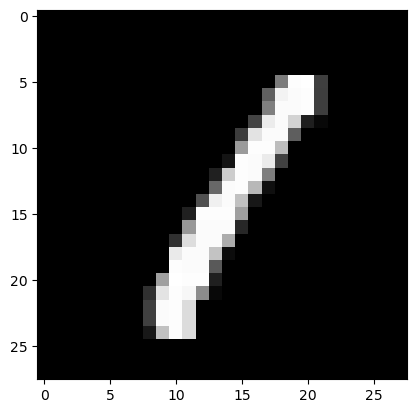

In [24]:
image_index = 3 ## Change me to view different images

print("Label: ", y_train[image_index])
reshaped_image = X_train[image_index].reshape((28, 28))

plt.imshow(reshaped_image, cmap='gray')
plt.show()

## Question 2 - Training the Model
Now that we have formatted our data, we can fit a model using sklearn's `RandomForestClassifier` class with 20 estimators and its random_state is set to 42. We'll write a function that will take as input the image and label variables that we created previously, and return a trained model.

_**Function Specifications:**_
* Should take two numpy `arrays` as input in the form `(X_train, y_train)`.
* Should return an sklearn `RandomForestClassifier` model which has a random state of 42 and number of estimators 20.
* The returned model should be fitted to the data.

In [27]:
### START FUNCTION
from sklearn.ensemble import RandomForestClassifier
def train_model(X_train, y_train):
   


    # Create a RandomForestClassifier with 20 estimators and random state 42
    model = RandomForestClassifier(n_estimators=20, random_state=42)

    # Fit the model to the training data
    model.fit(X_train, y_train)

    return model

# Example usage:
# Assuming you have already loaded and preprocessed the data using the get_data function
(X_train, y_train), _ = get_data(num_train_images=5000, num_test_images=1000)

# Train the RandomForestClassifier
#random_forest_model = train_model(X_train, y_train)
    #your code here
   # return 

### END FUNCTION

In [28]:
clf = train_model(X_train, y_train)

## Question 3 - Testing the model
Now that you have trained your model, lets see how well it does on the test set. Write a function which returns the accuracy of your trained model when tested with the test set.

_**Function Specifications:**_
* Should take the fitted model and two numpy `arrays` `X_test, y_test` as input.
* Should return a `float` of the accuracy of the model. This number should be between zero and one.

In [40]:
### START FUNCTION
#def calculate_accuracy(clf, X_test, y_test):
from sklearn.metrics import accuracy_score

def calculate_accuracy(model, X_test, y_test):
    # Flatten the images if needed
    X_test_flattened = X_test.reshape((X_test.shape[0], -1))

    # Predict labels for the test set
    y_pred = model.predict(X_test_flattened)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy

# Example usage:
# Assuming you have a trained model and X_test, y_test from the get_data function
accuracy = calculate_accuracy(random_forest_model, X_test, y_test)
print("Accuracy:", accuracy)


from sklearn.metrics import precision_score

def calculate_precision_for_label(model, X_test, y_test, label):
    # Flatten the images if needed
    X_test_flattened = X_test.reshape((X_test.shape[0], -1))

    # Predict labels for the test set
    y_pred = model.predict(X_test_flattened)

    # Calculate precision for the specified label
    precision = precision_score(y_test, y_pred, labels=[label], average='micro')
    
    return precision

# Example usage:
# Assuming you have a trained model and X_test, y_test from the get_data function
precision_label_6 = calculate_precision_for_label(random_forest_model, X_test, y_test, label=6)
print("Precision for label 6:", precision_label_6)


from sklearn.metrics import f1_score

def calculate_f1_score_for_label(model, X_test, y_test, label):
    # Flatten the images if needed
    X_test_flattened = X_test.reshape((X_test.shape[0], -1))

    # Predict labels for the test set
    y_pred = model.predict(X_test_flattened)

    # Calculate F1-score for the specified label
    f1_score_label_0 = f1_score(y_test, y_pred, labels=[label], average='micro')
    
    return f1_score_label_0

# Example usage:
# Assuming you have a trained model and X_test, y_test from the get_data function
f1_score_label_0 = calculate_f1_score_for_label(random_forest_model, X_test, y_test, label=0)
print("F1-score for label 0:", f1_score_label_0)
    #your code here
    #return 

### END FUNCTION

Accuracy: 0.891
Precision for label 6: 0.9101123595505618
F1-score for label 0: 0.9655172413793103


In [35]:
print(calculate_accuracy(clf,X_test,y_test))

0.891


Classification reports gives us more information on where our model is going wrong - looking specifically at the performance caused by Type I & II errors. Write a function which returns the classification report of your test set.

_**Function Specifications:**_
* Should take the fitted model and two numpy `arrays` `X_test, y_test` as input.
* Should return a classification report

_**Hint**_ You don't need to do this manually, sklearn has a classification report function.

In [38]:
### START FUNCTION
#def get_class_report(clf, X_test, y_test):
from sklearn.metrics import classification_report

def generate_classification_report(model, X_test, y_test):
    # Flatten the images if needed
    X_test_flattened = X_test.reshape((X_test.shape[0], -1))

    # Predict labels for the test set
    y_pred = model.predict(X_test_flattened)

    # Generate the classification report
    report = classification_report(y_test, y_pred)
    
    return report

# Example usage:
# Assuming you have a trained model and X_test, y_test from the get_data function
classification_report_result = generate_classification_report(random_forest_model, X_test, y_test)
print("Classification Report:")
print(classification_report_result)
    #your code here
   # return

### END FUNCTION

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97        85
           1       0.98      0.98      0.98       126
           2       0.88      0.90      0.89       116
           3       0.84      0.83      0.84       107
           4       0.86      0.90      0.88       110
           5       0.86      0.85      0.86        87
           6       0.91      0.93      0.92        87
           7       0.88      0.85      0.87        99
           8       0.93      0.78      0.85        89
           9       0.81      0.88      0.85        94

    accuracy                           0.89      1000
   macro avg       0.89      0.89      0.89      1000
weighted avg       0.89      0.89      0.89      1000



In [ ]:
print(get_class_report(clf,X_test,y_test))

## Plotting the results

Lets actually see if your model has trained correctly. Lets plot some of the images with their predicted labels. Since we don't have the predictions stored in our notebooks memory, we need to call the predict function here first.

Predicted label for image at index 15: 5
Predicted Label:  2


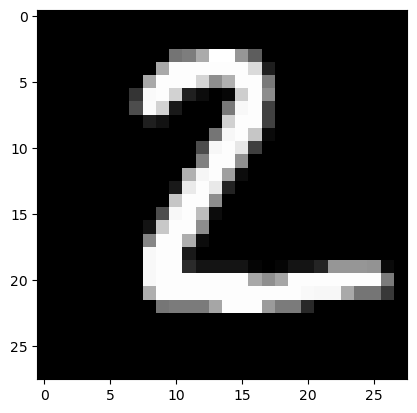

In [41]:
# Assuming you have a trained model (e.g., random_forest_model)
# and X_test from the get_data function
(_, _), (X_test, _) = get_data(num_train_images=5000, num_test_images=1000)

# Flatten the image if needed
X_test_flattened = X_test.reshape((X_test.shape[0], -1))

# Get the predicted label for image at index 15
predicted_label_index_15 = random_forest_model.predict(X_test_flattened[15:16])[0]

print("Predicted label for image at index 15:", predicted_label_index_15)




preds = clf.predict(X_test)

image_index = 1 ## Change me to see other predictions

print("Predicted Label: ",preds[image_index])
plt.imshow(X_test[image_index].reshape((28, 28)), cmap='gray')
plt.show()

Nice work! Since we didn't use all the data in the beginning, there is a chance our performance can improve. Go change the amount of data we use to see how it affects the accuracy of your model.